In [ ]:
import os
import random
import matplotlib.pyplot as plt

In [1]:
from utils.config import get_model_configurations, get_dataset_configurations
from utils.dataset_loader import load_dataset, create_sample_dataset, create_balanced_sample_dataset
from utils.ocr_evaluator import run_ocr_evaluation, calculate_metrics, print_summary_statistics

models_to_test = get_model_configurations()
datasets_to_test = get_dataset_configurations()

EVALUATION_SAMPLE_SIZE = 300
USE_BALANCED_SAMPLING = True

Loaded 3 models for testing:
- base_model
- custom_thai_1500_iteration
- custom_thai_15000_iteration
Loaded 2 datasets:
- data_from_outsource (bbox_json) - 4985 files
- data_from_web (full_image) - 10000 files


In [2]:
all_results = []
for dataset in datasets_to_test:
    print(f"\nProcessing dataset: {dataset['name']}")
    if USE_BALANCED_SAMPLING and EVALUATION_SAMPLE_SIZE != -1:
        test_dataset = create_balanced_sample_dataset(dataset, EVALUATION_SAMPLE_SIZE)
        if 'estimated_images' in test_dataset:
            print(f"🎯 Balanced sampling: Using ~{test_dataset['estimated_images']} images to target {EVALUATION_SAMPLE_SIZE} samples")
    else:
        test_dataset = create_sample_dataset(dataset, EVALUATION_SAMPLE_SIZE)
    dataset_results = load_dataset(test_dataset, test_dataset['type'])
    
    if len(dataset_results) == 0:
        print(f"⚠️  No data loaded for {dataset['name']}")
        continue
    
    expected_msg = "full dataset" if EVALUATION_SAMPLE_SIZE == -1 else f"~{EVALUATION_SAMPLE_SIZE} samples"
    print(f"📊 Using {len(dataset_results)} samples for evaluation (target: {expected_msg})")
    
    # Run OCR evaluation with all models
    model_results = run_ocr_evaluation(models_to_test, dataset_results, dataset['name'])
    all_results.extend(model_results)

print(f"\n✓ Total processed results: {len(all_results)}")
sampling_type = "Balanced" if USE_BALANCED_SAMPLING else "Standard"
print(f"📈 {sampling_type} sampling for fairer comparison across datasets")


Processing dataset: data_from_outsource
🎯 Balanced sampling for bbox_json: 100 images → target 300 samples
🎯 Balanced sampling: Using ~100 images to target 300 samples
Loading dataset: data_from_outsource (type: bbox_json)
DataFrame shape: (100, 4)
Using JSON column: 'new_json_name', Image column: 'new_image_name'


Processing bbox_json:  69%|██████▉   | 69/100 [00:01<00:00, 38.73it/s]


Loaded 300 samples
📊 Using 300 samples for evaluation (target: ~300 samples)
  Testing model: base_model


OCR with base_model:   0%|          | 0/300 [00:00<?, ?it/s]/Users/puem/Documents/NECTEC/tmp/easyocr_test/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
OCR with base_model: 100%|██████████| 300/300 [00:25<00:00, 11.95it/s]


  Completed 300 images
  Testing model: custom_thai_1500_iteration


OCR with custom_thai_1500_iteration: 100%|██████████| 300/300 [00:40<00:00,  7.49it/s]


  Completed 300 images
  Testing model: custom_thai_15000_iteration


OCR with custom_thai_15000_iteration: 100%|██████████| 300/300 [00:40<00:00,  7.48it/s]


  Completed 300 images

Processing dataset: data_from_web
Loading dataset: data_from_web (type: full_image)
DataFrame shape: (300, 2)
Using file column: 'filename', text column: 'words'


Processing full_image: 100%|██████████| 300/300 [00:00<00:00, 2709.39it/s]


Loaded 300 samples
📊 Using 300 samples for evaluation (target: ~300 samples)
  Testing model: base_model


OCR with base_model: 100%|██████████| 300/300 [00:14<00:00, 20.92it/s]


  Completed 300 images
  Testing model: custom_thai_1500_iteration


OCR with custom_thai_1500_iteration: 100%|██████████| 300/300 [00:13<00:00, 21.59it/s]


  Completed 300 images
  Testing model: custom_thai_15000_iteration


OCR with custom_thai_15000_iteration: 100%|██████████| 300/300 [00:13<00:00, 21.89it/s]

  Completed 300 images

✓ Total processed results: 1800
📈 Balanced sampling for fairer comparison across datasets


[{'dataset_name': 'data_from_outsource', 'model_name': 'base_model', 'source_file': 'd7110ab5-04a9-40eb-bf73-c28f15d26c84.json', 'box_index': 0, 'cropped_image': <PIL.Image.Image image mode=RGB size=1199x113 at 0x169FDA080>, 'ground_truth': 'เนทันยาฮูประกาศโจมตีใส่ฮูตีขั้นเด็ดขาด', 'ocr_text': 'เนทันยาอูประกาศโจมตีใส่ฮูตีขันเด็ดขาด'}, {'dataset_name': 'data_from_outsource', 'model_name': 'base_model', 'source_file': 'd7110ab5-04a9-40eb-bf73-c28f15d26c84.json', 'box_index': 1, 'cropped_image': <PIL.Image.Image image mode=RGB size=130x172 at 0x169485E10>, 'ground_truth': 'tnn16live', 'ocr_text': 'es'}, {'dataset_name': 'data_from_outsource', 'model_name': 'base_model', 'source_file': 'd7110ab5-04a9-40eb-bf73-c28f15d26c84.json', 'box_index': 2, 'cropped_image': <PIL.Image.Image image mode=RGB size=1427x66 at 0x1694868F0>, 'ground_truth': 'รมว.ต่างประเทศตุรกีพบตัวแทนรัฐบาลชุดใหม่ซีเรีย ให้คำมั่นจะช่วยฟื้นฟูบ้านเมืองจากสงคราม', 'ocr_text': 'รมว.ต่างประเทศตุรกีพบตัวแทนรัฐบาลชุดไหม่ซีเรีย ให้

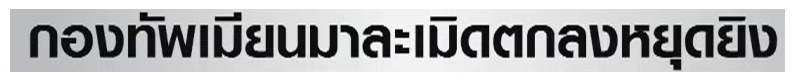

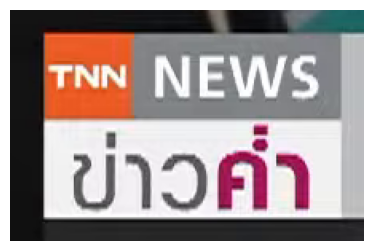

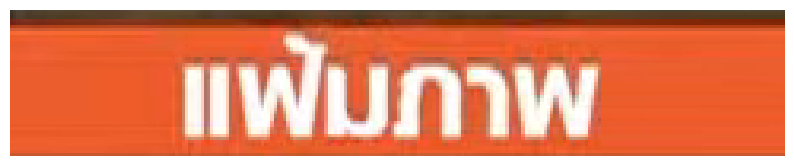

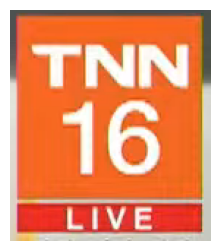

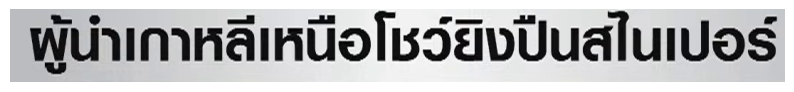

In [ ]:
print(all_results)
types_list = [result['dataset_name'] for result in all_results]
print(f"🔍 Types of results collected: {set(types_list)}")

img = [x for x in all_results if x['dataset_name'] == 'data_from_outsource' and x['model_name'] == 'base_model']
random.seed(47)
img = random.sample(img, min(5, len(img)))
# for i, in enumerate(img):
for index, val in enumerate(img):
    plt.figure(figsize=(10, 3))
    plt.imshow(val['cropped_image'])
    plt.axis('off')
    os.makedirs("tmp", exist_ok=True)
    plt.savefig(f"tmp/sample_image_{index+1}_{val['dataset_name']}_{val['model_name']}.png", bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [ ]:
print("=== METRICS CALCULATION ===")
if len(all_results) > 0:
    metrics_output_path = './evaluation_results.json'
    individual_metrics = calculate_metrics(all_results, metrics_output_path)
    print_summary_statistics(individual_metrics)
    print(f"\n✓ Evaluation complete! Results saved to {metrics_output_path}")
else:
    print("⚠️  No results to calculate metrics")